# 15wk-2: 기말고사

최규빈  
2024-06-13

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/15wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

In [156]:
import torch
import numpy as np
import matplotlib.pyplot as plt
#--# 문제1
import pandas as pd
import sklearn.model_selection
#--# 문제3
import gymnasium as gym
import IPython
from matplotlib.animation import FuncAnimation
import collections
import random

# `1`. 추천시스템 – 30점

In [212]:
!wget http://files.grouplens.org/datasets/movielens/ml-20m.zip
!unzip ml-20m.zip

--2024-06-16 15:03:12--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  2.83MB/s    in 65s     

2024-06-16 15:04:17 (2.94 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         

MovieLens 20M 데이터셋은 GroupLens Research에서 제공하는 영화 평점
데이터셋으로, 영화 추천 시스템 연구에 널리 사용된다. 이 데이터셋은 약
2천만 개의 영화 평점과 메타데이터를 포함하고 있다. 주요 파일과 그 내용은
다음과 같다:

`1`. **ratings.csv**:

-   **userId**: 사용자의 고유 ID
-   **movieId**: 영화의 고유 ID
-   **rating**: 사용자가 부여한 평점 (1.0에서 5.0 사이의 값)
-   **timestamp**: 평점이 부여된 시간 (유닉스 타임스탬프 형식)

`2`. **movies.csv**:

-   **movieId**: 영화의 고유 ID
-   **title**: 영화 제목
-   **genres**: 영화 장르 (여러 개의 장르가 ’\|’로 구분됨)

`3`. **tags.csv**:

-   **userId**: 사용자의 고유 ID
-   **movieId**: 영화의 고유 ID
-   **tag**: 사용자가 부여한 태그
-   **timestamp**: 태그가 부여된 시간 (유닉스 타임스탬프 형식)

`4`. **genome-scores.csv**:

-   **movieId**: 영화의 고유 ID
-   **tagId**: 태그의 고유 ID
-   **relevance**: 해당 태그가 영화에 얼마나 관련 있는지 나타내는 점수
    (0.0에서 1.0 사이의 값)

`5`. **genome-tags.csv**:

-   **tagId**: 태그의 고유 ID
-   **tag**: 태그의 이름

`6`. **links.csv**:

-   **movieId**: 영화의 고유 ID
-   **imdbId**: IMDB에서의 영화 ID
-   **tmdbId**: TMDB에서의 영화 ID

이중에서 1,2의 데이터만 사용하여 추천시스템을 설계하기로 하자.

In [41]:
df_ratings = pd.read_csv("ml-20m/ratings.csv")
df_movies = pd.read_csv("ml-20m/movies.csv")
df_train_all = pd.merge(df_ratings,df_movies)
userId_sampled = np.random.choice(df_train_all.userId.unique(),5000)
df_train = df_train_all.query("userId in @userId_sampled").reset_index(drop=True)
df_train["userId"] = df_train.userId.map({user:i for i,user in enumerate(set(df_train.userId))}) 
df_train["movieId"] = df_train.movieId.map({movie:i for i,movie in enumerate(set(df_train.movieId))}) 

평점정보와 영화정보를 결합하여 `df_train`을 만들었으며, 위의 코드를
간단히 설명하면 아래와 같다.

`1`. `df_ratings`와 `df_movies` CSV 파일을 읽어 데이터프레임으로 만든다.

``` python
df_ratings = pd.read_csv("ml-20m/ratings.csv")
df_movies = pd.read_csv("ml-20m/movies.csv")
```

`2`. 평점 데이터와 영화 데이터를 합쳐 하나의 데이터프레임
`df_train_all`을 만든다.

``` python
df_train_all = pd.merge(df_ratings, df_movies)
```

`3`. 데이터가 너무 많아 5000명의 유저만 랜덤으로 샘플링한다.

``` python
userId_sampled = np.random.choice(df_train_all.userId.unique(), 5000)
```

`4`. 샘플링된 5000명의 유저 데이터만 포함하는 새로운 데이터프레임
`df_train`을 만든다.

``` python
df_train = df_train_all.query("userId in @userId_sampled").reset_index(drop=True)
```

`5`. 유저 ID를 0부터 시작하는 인덱스로 재조정한다.

``` python
df_train["userId"] = df_train.userId.map({user: i for i, user in enumerate(set(df_train.userId))})
```

`6`. 영화 ID도 0부터 시작하는 인덱스로 재조정한다.

``` python
df_train["movieId"] = df_train.movieId.map({movie: i for i, movie in enumerate(set(df_train.movieId))})
```

In [216]:
df_train

`(1)` `df_train`을 아래와 같이 `X_train`, `X_val`, `y_train`, `y_val`로
나누고 적절한 추천시스템을 설계하고 학습하라. 학습결과를 **validation
loss**로 검증하라.

In [125]:
X1 = torch.tensor(df_train.userId)
X2 = torch.tensor(df_train.movieId)
X = torch.stack([X1,X2],axis=1)
y = torch.tensor(df_train.rating).float().reshape(-1,1)

In [126]:
X_train,X_val,y_train,y_val = sklearn.model_selection.train_test_split(X,y,test_size=0.1,random_state=42)

**(힌트)** 아래의 코드를 이용하라.

``` python
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #--#
        ????   
    def forward(self,X):
        ???
        return yhat
#---#
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
ds = torch.utils.data.TensorDataset(X_train,y_train)
dl = torch.utils.data.DataLoader(ds,batch_size=64,shuffle=True)
#--# 
for epoc in range(5):
    net.to("cuda:0")
    for xi,yi in dl:
        xi = xi.to("cuda:0")
        yi = yi.to("cuda:0")
        # 1
        yi_hat = net(xi) 
        # 2
        loss = loss_fn(yi_hat,yi)
        # 3 
        loss.backward()
        # 4 
        optimizr.step()
        optimizr.zero_grad()
    net.to("cpu")
    print(f"epoch: {epoc+1}\t val_loss: {loss_fn(net(X_val).data,y_val):.4f}")
```

In [139]:
# 학습결과

epoch: 1     val_loss: 0.8134
epoch: 2     val_loss: 0.7696
epoch: 3     val_loss: 0.7615
epoch: 4     val_loss: 0.7541
epoch: 5     val_loss: 0.7517

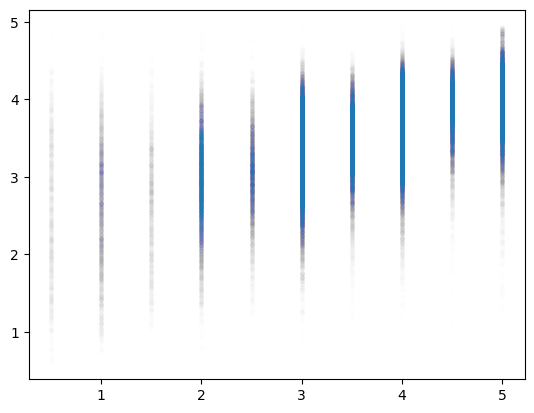

In [153]:
# 시각화 
plt.plot(y_val,net(X_val).data,'.',alpha=0.002)

-   전체적으로 우상향 $\to$ 그럭저럭 잘맞춤

`(2)` 아래는 유저 2265에 대한 정보이다.

In [154]:
df_train.query("userId == 2265") # 스릴러 좋아하는듯

유저 2265는 스릴러를 좋아하는 것 같다. (그리고 전체적으로 평점도 잘 주는
편이다) 영화 {49: `Usual Suspects, The (1995)`} 는 스리럴중에서도 인기가
있는 영화인데, 유저 2265는 아직 이 영화를 시청하지 않은듯 보인다.

In [151]:
df_train.query("movieId == 49")

유저 2265에게 이 영화를 추천하면 어떠한 평점을 줄까? (1)에서 학습한
네트워크로 예측하여 보라.

# 2. `hello` – 30점

아래와 같이 hello가 반복되는 자료가 있다고 하자.

In [229]:
txt = list('hello')*100
txt[:10]

`(1)` `torch.nn.RNN()`을 이용하여 다음문자를 예측하는 신경망을 설계하고
학습하라. – 12wk-2, 3-C 참고

`(2)` `torch.nn.RNNCell()`을 이용하여 다음문자를 예측하는 신경망을
설계하고 학습하라. – 12wk-1, hw 참고

`(3)` `(2)`의 결과와 동일한 적합값을 출력하는 신경망을 직접설계한뒤
학습시켜라. (초기값을 적절하게 설정할 것)

``` python
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = ????
        self.h2h = ????
        self.tanh = ????
    def forward(self,??,??):
        ht = ????
        return ht
```

위의 클래스의 `????`를 체워 (2)의 결과와 동일한 적합값이 나오도록 하라.
– 12wk-1, hw 참고

-   class를 이용하지 않으면 점수없음.
-   `torch.nn.RNN()`, `torch.nn.RNNCell()` 을 이용한 네트워크를
    학습시킬시 점수 없음. (초기값을 셋팅하는 용도로는 torch.nn.RNN(),
    torch.nn.RNNCell()을 코드에 포함시키는 것이 가능)

`(4)` `torch.nn.LSTM()`을 이용하여 다음문자를 예측하는 신경망을 설계하고
학습하라. – 13wk-1, 4-C 참고

`(5)` `torch.nn.LSTMCell()`을 이용하여 다음문자를 예측하는 신경망을
설계하고 학습하라. – 13wk-1, 4-A 참고

`(6)` `(5)`’의 결과와 동일한 적합값을 출력하는 신경망을 직접설계한 뒤
학습시켜라. (초기값을 적절하게 설정할 것) – 13wk-1, 4-B 참고

-   class를 이용하지 않아도 무방함.
-   torch.nn.LSTM(), torch.nn.LSTMCell() 을 이용한 네트워크를 학습시킬시
    점수 없음. (초기값을 셋팅하는 용도로는 torch.nn.LSTM(),
    torch.nn.LSTMCell()을 코드에 포함시키는 것은 가능)

> 이 문제는 전체적으로
> <https://guebin.github.io/DL2022/posts/2022-11-29-13wk-2-final.html>
> 의 1번과 비슷하니 해당문제 정답을 참고하셔도 됩니다. (근데 뭔가 제가
> 다시보니까 데이터정리하는 방식등이 미묘하게 좀 바껴있어서요, 올해
> 강의노트에서 보고 베끼는게 좋을것 같습니다. 이건 뭐 알아서하세요)

# 3. `FrozenLake`

ref: <https://www.gymlibrary.dev/environments/toy_text/frozen_lake/>

아래는 OpenAI Gym 라이브러리에서 제공하는 환경 Frozen Lake를 구체화하여
변수 `env`에 저장하는 코드이다.

In [39]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode='rgb_array')

Frozen Lake 환경은 강화학습(RL) 실험을 위한 간단한 시뮬레이션 환경으로
에이전트가 얼어붙은 호수 위를 안전하게 건너 목표 지점에 도달하는 것이
목표이다. 주요 특징은 다음과 같다.

`1`. **환경 구성**: - 격자형(grid) 환경으로 이루어져 있으며, 각 격자는
4x4 또는 8x8의 형태를 가질 수 있다. (문제에서는 4x4) - 격자는 시작
지점(Start), 목표 지점(Goal), 얼음(Ice), 그리고 구멍(Hole)으로
구성된다. - 에이전트는 시작 지점에서 목표 지점까지 이동해야 한다.

`2`. **에이전트의 동작**: - 에이전트는 상, 하, 좌, 우로 이동할 수
있다. - 얼음 위에서는 자유롭게 이동할 수 있지만, 구멍에 빠지면
에피소드가 종료된다.

`3`. **보상 체계**: - 에이전트가 목표 지점에 도달하면 +1의 보상을
받는다. - 그 외에는 보상이 없다(0 보상). - 구멍에 빠지거나 목표 지점에
도달하지 못하면 보상은 없다.

`4`. **목표**: - 에이전트는 강화학습 알고리즘을 사용하여 최적의 경로를
학습하고, 가능한 한 구멍에 빠지지 않고 목표 지점에 도달하는 것이다.

아래는 `show` 함수이며, 이는 `env`의 현재상태를 렌더링해주는 역할을
한다.

In [35]:
def show(ims):
    fig = plt.Figure()
    ax = fig.subplots()
    def update(i):
        ax.imshow(ims[i])
    ani = FuncAnimation(fig,update,frames=len(ims))
    display(IPython.display.HTML(ani.to_jshtml()))

`show()` 함수의 사용방법은 아래와 같다.

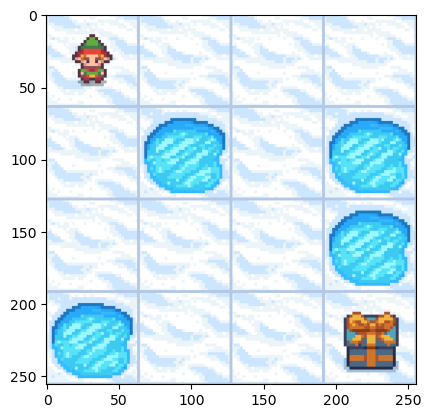

In [36]:
env.reset()
plt.imshow(env.render())

적당한 위의 환경에 대응하는 Agent를 설계하고 `q_net`를 이용하여 올바른
행동을 학습하라. 아래는 학습된 결과의 예시이다.

In [22]:
# 학습과정 -- 제가 설정한 게임 클리어 판단 조건은 최근 100번의 score가 0.9 이상일경우입니다. 

에피소드:500    경험(t):3048  점수(에피소드):0.08   게임시간(에피소드):6.10 돌발행동(에피소드):0.61
에피소드:1000   경험(t):5824  점수(에피소드):0.29   게임시간(에피소드):5.55 돌발행동(에피소드):0.37
에피소드:1500   경험(t):8768  점수(에피소드):0.54   게임시간(에피소드):5.89 돌발행동(에피소드):0.22
에피소드:2000   경험(t):11134 점수(에피소드):0.41   게임시간(에피소드):4.73 돌발행동(에피소드):0.14
에피소드:2500   경험(t):14067 점수(에피소드):0.78   게임시간(에피소드):5.87 돌발행동(에피소드):0.08
---game cleared in 2832 episodes! ---

In [33]:
show(imgs)

**힌트1:** 아래의 에이전트를 설계에 이용하라.

In [31]:
class AgentRandom: 
    def __init__(self,env):
        #--# define spaces 
        self.action_space = env.action_space
        self.state_space = env.observation_space
        #--# replay buffer 
        self.current_state =  None   
        self.action = None           
        self.reward = None           
        self.next_state =  None      
        self.terminated = None       
        #-#
        self.buffer_size = 50000
        self.current_states = collections.deque(maxlen=self.buffer_size)
        self.actions = collections.deque(maxlen=self.buffer_size)
        self.rewards = collections.deque(maxlen=self.buffer_size)
        self.next_states = collections.deque(maxlen=self.buffer_size)
        self.terminations = collections.deque(maxlen=self.buffer_size)
        #--# other information 
        self.n_episodes = 0         
        self.n_experiences = 0
        self.playtimes = [] 
        self.score = 0                
        self.scores = []
    def act(self):
        self.action = self.action_space.sample()
    def learn(self):
        pass 
    def save_experience(self):
        self.current_states.append(torch.tensor(self.current_state))
        self.actions.append(torch.tensor(self.action))
        self.rewards.append(torch.tensor(self.reward).float())
        self.next_states.append(torch.tensor(self.next_state))
        self.terminations.append(torch.tensor(self.terminated))           
        #--#
        self.n_experiences = self.n_experiences + 1 
        self.score = self.score + self.reward

**힌트2**: `q_net`의 첫 레이어는 `torch.nn.Embedding()`을 이용하라.

-   상태공간(state space)가 0~15일텐데, 상태 0에서 +1 하면 상태1을
    의미하는게 아니기 때문에 상태공간은 카테고리로 봐야겠죠?

# 4. O/X – 10점

다음을 읽고 참 거짓을 판단하라.

`(1)` Dropout Layer를 추가하면 layer의 추가로 인해 모형이 더 복잡해지며
그 결과 모형이 과적합될 수 있다.